# Objective
The goal of this data analysis project is to explore the sensor patterns from three IoT devices in different environments, and to identify characteristics of the environment and correlations between sensor readouts.

There are three IoT devices, and each device contain seven sensors, including temperature, humidity, CO, liquid petroleum gas (LPG), smoke, light, and motion. Since these devices are placed in different environments, the sensor data may exhibit distinct patterns that are characteristic of the specific environment.

Using data-driven methods, we will explore the seasonality properties in sensor readouts, make inference about the characteristics of each environment, and discover correlation between sensors via visualizing the daily trends of sensor readouts, generating insights for IoT device deployment and efficient environmental control.

# Loading and Preprocessing

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pandas.plotting import autocorrelation_plot

data = pd.read_csv(r"C:\Users\HP\Desktop\iot_telemetry_data.csv", engine='python')
data.head()

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000


In [4]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
ts          0
device      0
co          0
humidity    0
light       0
lpg         0
motion      0
smoke       0
temp        0
dtype: int64


In [5]:
# Basic information about the dataset
print("\nDataset Info:")
data.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405184 entries, 0 to 405183
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ts        405184 non-null  float64
 1   device    405184 non-null  object 
 2   co        405184 non-null  float64
 3   humidity  405184 non-null  float64
 4   light     405184 non-null  bool   
 5   lpg       405184 non-null  float64
 6   motion    405184 non-null  bool   
 7   smoke     405184 non-null  float64
 8   temp      405184 non-null  float64
dtypes: bool(2), float64(6), object(1)
memory usage: 22.4+ MB


Since the 'light' and 'motion' columns are boolean, we transform them into 0 and 1.

In [7]:
# Transforming boolean columns 'light' and 'motion' into integers
data['light'] = data['light'].astype(int)
data['motion'] = data['motion'].astype(int)

# convert unix time to time of day
from datetime import datetime, timedelta
start = datetime(1970, 1, 1)  # Unix epoch start time
data['datetime'] = data.ts.apply(lambda x: start + timedelta(seconds=x))
data = data.drop('ts', axis=1)

# Convert the 'datetime' column to a datetime object, and make datetime column into index column for convenience
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)
data.head(5)

,device,co,humidity,light,lpg,motion,smoke,temp
datetime,,,,,,,,
2020-07-12 00:01:34.385975,b8:27:eb:bf:9d:51,0.004956,51.000000,0,0.007651,0,0.020411,22.700000
2020-07-12 00:01:34.735568,00:0f:00:70:91:0a,0.002840,76.000000,0,0.005114,0,0.013275,19.700001
2020-07-12 00:01:38.073573,b8:27:eb:bf:9d:51,0.004976,50.900000,0,0.007673,0,0.020475,22.600000
2020-07-12 00:01:39.589146,1c:bf:ce:15:ec:4d,0.004403,76.800003,1,0.007023,0,0.018628,27.000000
2020-07-12 00:01:41.761235,b8:27:eb:bf:9d:51,0.004967,50.900000,0,0.007664,0,0.020448,22.600000


In [8]:
# Grouping data by 'device' and creating a separate DataFrame for each device
device_groups = data.groupby('device')

# Dictionary to store each device's DataFrame
device_df = {}

for device, group in device_groups:
    device_df[device] = group

## Past Data Analysis

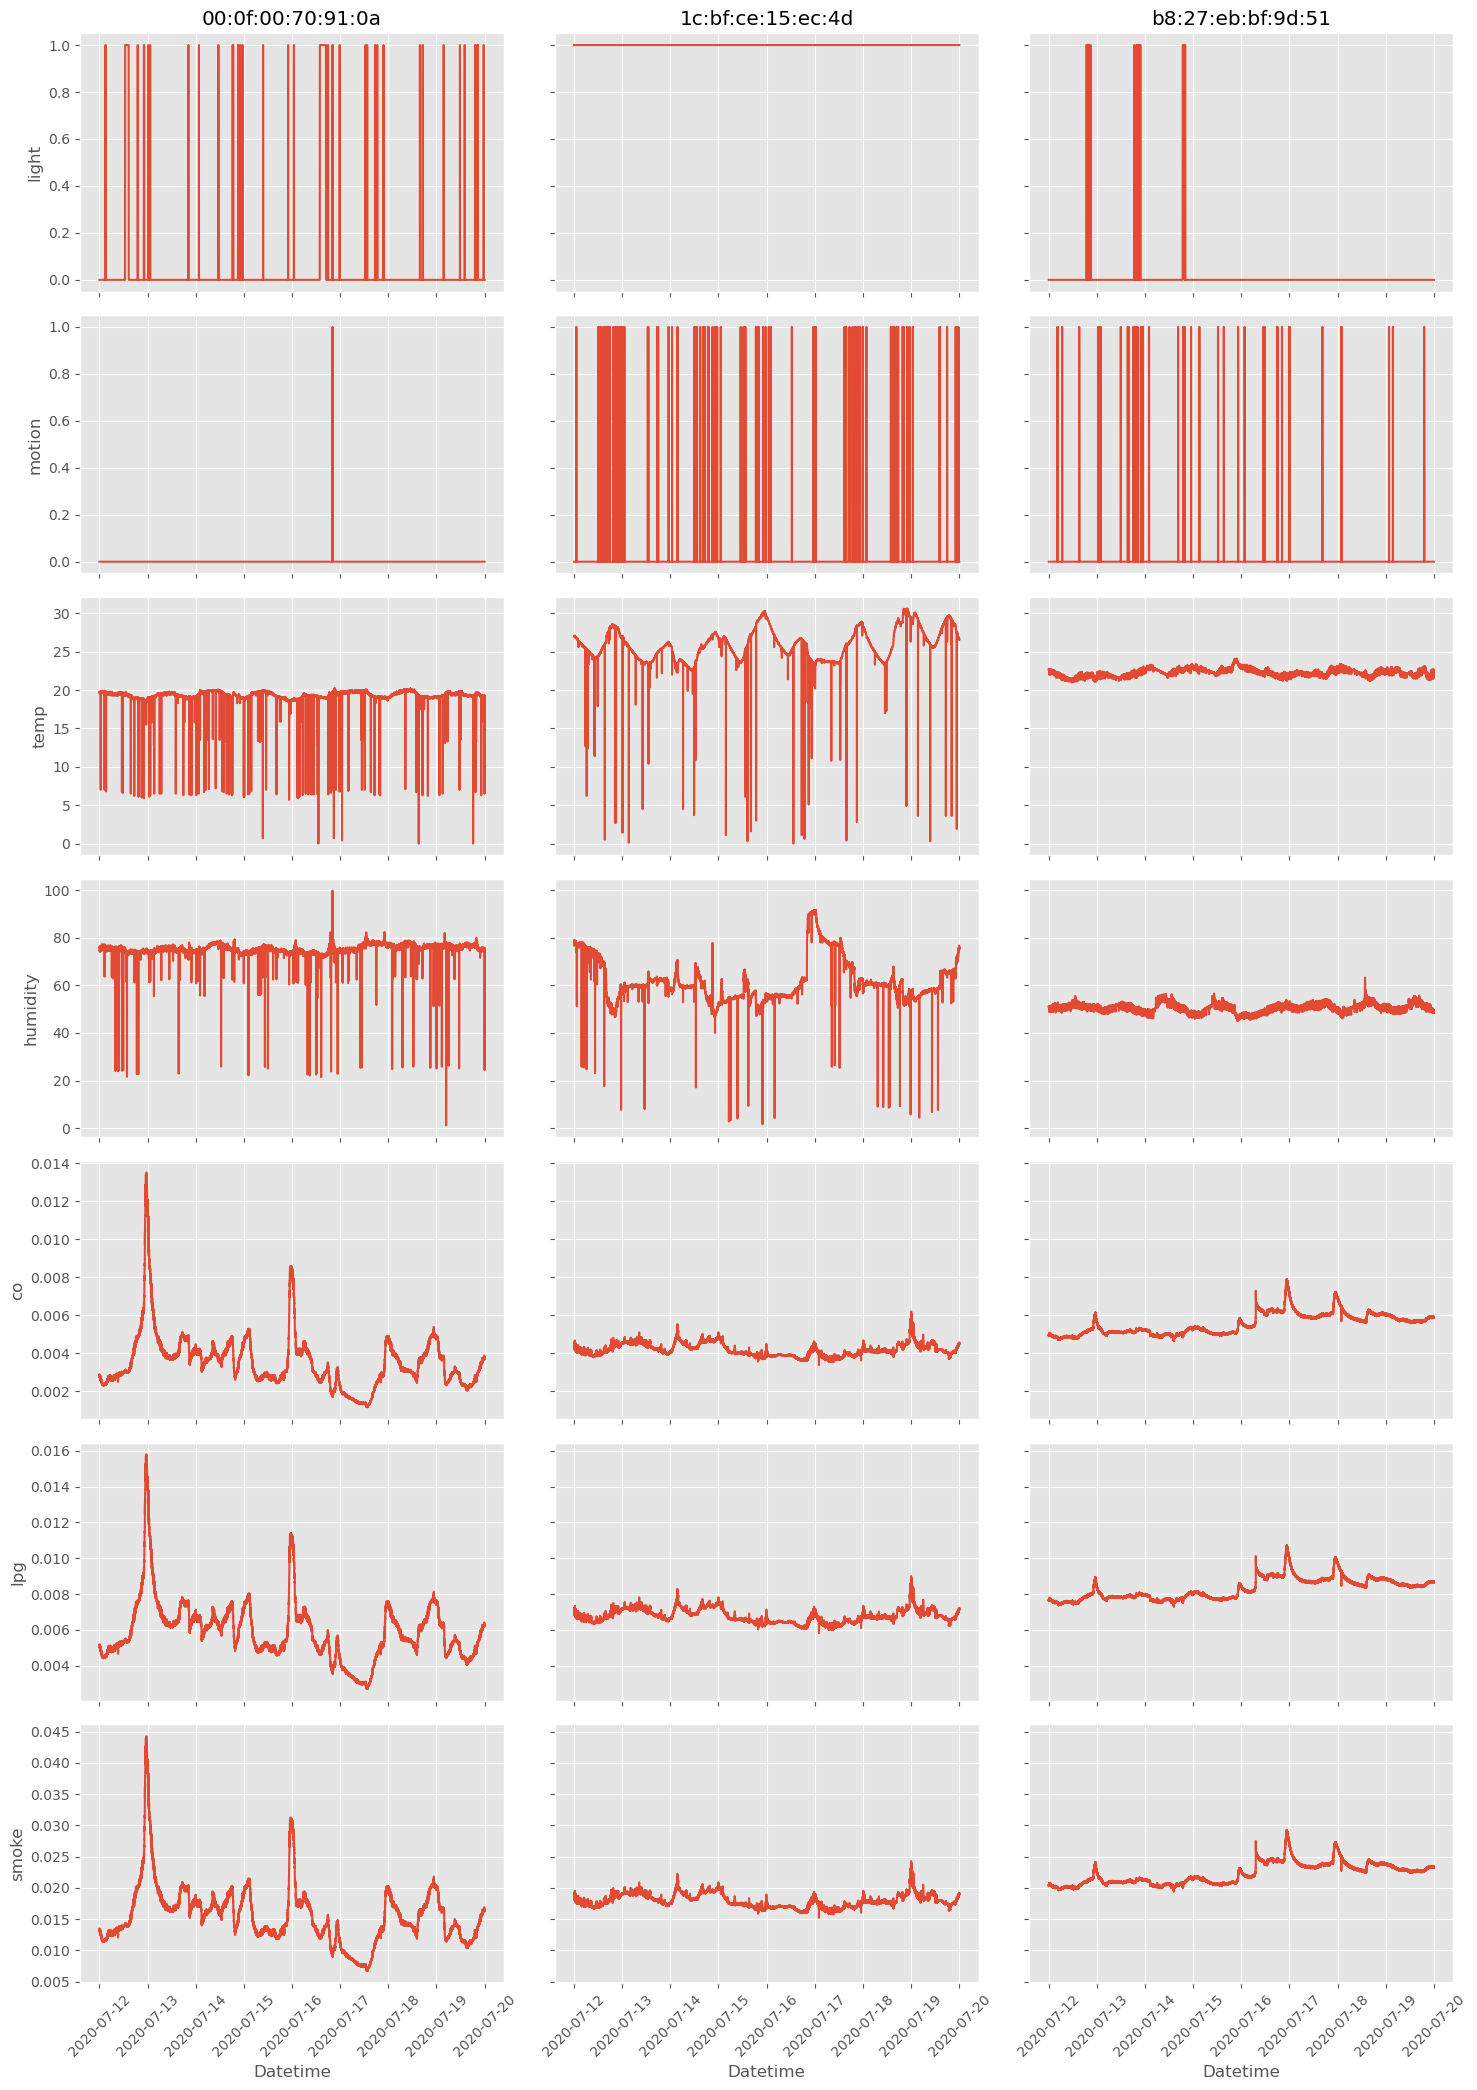

In [10]:
def plot_device_sensors(device_df, undersample_rate=1):
    """
    Plot sensor data for each device with aligned axes.

    Args:
    - device_df (dict): Dictionary with device IDs as keys and DataFrames as values.
    - undersample_rate (int): Rate at which to undersample the data for plotting efficiency. Default is 1 (no undersampling).
    """

    # Sensors in the desired order
    sensors = ['light', 'motion', 'temp', 'humidity', 'co', 'lpg', 'smoke']

    # Number of devices and sensors
    num_devices = len(device_df)
    num_sensors = len(sensors)

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=num_sensors, ncols=num_devices, figsize=(num_devices * 5, num_sensors * 3), sharex='col', sharey='row')

    # Iterate through each device and sensor
    for j, (device_id, df) in enumerate(device_df.items()):
        # Undersample the data
        df_undersampled = df.iloc[::undersample_rate, :]

        for i, sensor in enumerate(sensors):
            # Plot each sensor in a separate subplot
            sns.lineplot(data=df_undersampled, x=df_undersampled.index, y=sensor, ax=axes[i, j])
            axes[i, j].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

            # Set x and y labels
            if j == 0:  # Only set y-axis label for the first column
                axes[i, j].set_ylabel(sensor)
            if i == num_sensors - 1:  # Only set x-axis label for the bottom row
                axes[i, j].set_xlabel('Datetime')
            else:
                axes[i, j].set_xlabel('')

            # Set titles for the first row and first column
            if i == 0:
                axes[i, j].set_title(device_id)

    plt.tight_layout()
    plt.show()

plot_device_sensors(device_df, undersample_rate=2)

### Device: 00:0f:00:70:91:0a

**Light & Motion**: Frequent fluctuations, suggesting this device is in a dynamic environment with varying light conditions and occasional movement.

**Temperature & Humidity**: Shows moderate fluctuations but remains relatively stable, indicating a semi-controlled indoor environment.

**CO, LPG, Smoke**: Peaks in gas concentrations suggest periodic emissions, possibly from machinery, cooking, or human activity.

### Device: 1c:bf:ce:15:ec:4d**

**Light**: Appears to remain constant, possibly indicating a space with a consistent light source or complete darkness.

**Motion**: Highly active with frequent motion detections, suggesting human presence or operational activity.

**Temperature & Humidity**: Large fluctuations with noticeable daily trends, pointing to an environment affected by human activity or external factors like open windows or HVAC usage.

**CO, LPG, Smoke**: More stable than the first device, with fewer peaks, implying lower exposure to pollutants or emissions.

### Device: b8:27:eb:bf:9d:51

**Light & Motion**: Sparse motion detections with long inactive periods suggest a low-traffic environment. Clusters of motion spikes indicate brief, infrequent activity, possibly from occasional visits.

**Temperature & Humidity**: Extremely stable, indicating a well-controlled space, such as a storage room or a server room.

**CO, LPG, Smoke**: Shows occasional peaks, but overall trends remain smooth, suggesting mild pollution exposure, possibly due to occasional air circulation.

### To sum up,
Device 00:0f:00:70:91:0a is likely placed in an active indoor space with periodic emissions and movement.

Device 1c:bf:ce:15:ec:4d is in a high-traffic or human-occupied area, given the strong motion and temperature variations.

Device b8:27:eb:bf:9d:51 is in a stable, controlled environment with minimal disruptions, possibly a storage or data center.

The graphs show similar peaks and trends for CO, LPG, and smoke across all three devices, suggesting a possible correlation.

### Removing redundancies
The above chart infers a possible correlation between CO, LPG, and smoke across all three devices. We plot the correlation matrix to confirm the
correlation between features.

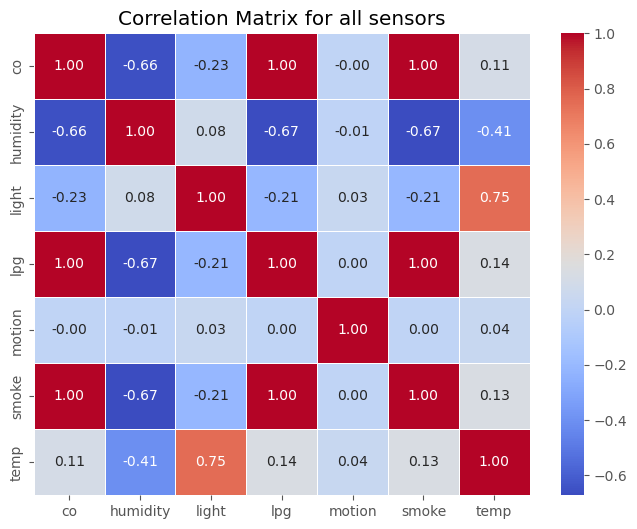

In [13]:
# Drop the sensor column
corr_data = data.drop(['device'],axis=1)

# Compute the correlation matrix
corr_matrix = corr_data.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for all sensors')
plt.show()

The strong correlation is verified, so we remove lpg and smoke as they do not provide new information.

In [15]:
# Iterating through the dictionary and removing 'lpg' and 'smoke' columns
for device_id, df in device_df.items():
    device_df[device_id] = df.drop(columns=['lpg', 'smoke'])

device_df

{'00:0f:00:70:91:0a':                                        device        co   humidity  light  \
 datetime                                                                    
 2020-07-12 00:01:34.735568  00:0f:00:70:91:0a  0.002840  76.000000      0   
 2020-07-12 00:01:46.869076  00:0f:00:70:91:0a  0.002938  76.000000      0   
 2020-07-12 00:02:02.785732  00:0f:00:70:91:0a  0.002905  75.800003      0   
 2020-07-12 00:02:11.476376  00:0f:00:70:91:0a  0.002938  75.800003      0   
 2020-07-12 00:02:15.289086  00:0f:00:70:91:0a  0.002840  76.000000      0   
 ...                                       ...       ...        ...    ...   
 2020-07-20 00:03:16.329782  00:0f:00:70:91:0a  0.003745  75.300003      0   
 2020-07-20 00:03:20.684223  00:0f:00:70:91:0a  0.003745  75.400002      0   
 2020-07-20 00:03:25.039890  00:0f:00:70:91:0a  0.003745  75.400002      0   
 2020-07-20 00:03:33.162015  00:0f:00:70:91:0a  0.003745  75.300003      0   
 2020-07-20 00:03:36.979522  00:0f:00:70:91

### Calculate sampling rates
In this grouped data, we can find that these several devices have different sampling rate, so we will calculate them here for later use.

In [17]:
def calculate_sampling_stats(device_df):
    sampling_stats = {}

    for device_id, df in device_df.items():
        # Calculate time differences between consecutive data points
        time_diffs = df.index.to_series().diff().dropna()

        # Convert time differences to a consistent unit, e.g., seconds
        time_diffs_in_seconds = time_diffs.dt.total_seconds()

        # Calculate mean and standard deviation
        mean_sampling_rate = time_diffs_in_seconds.mean()
        std_sampling_rate = time_diffs_in_seconds.std()

        # Store in dictionary
        sampling_stats[device_id] = {'mean': mean_sampling_rate, 'std': std_sampling_rate}

    return sampling_stats

# Calculate sampling stats for each device
device_sampling_stats = calculate_sampling_stats(device_df)
for device, stats in device_sampling_stats.items():
    print(f"Device {device} - Mean Sampling Rate: {stats['mean']}s, Std Dev: {stats['std']}s")

Device 00:0f:00:70:91:0a - Mean Sampling Rate: 6.182787879460532s, Std Dev: 2.5363540690275266s
Device 1c:bf:ce:15:ec:4d - Mean Sampling Rate: 6.526965254047981s, Std Dev: 3.0185357592392035s
Device b8:27:eb:bf:9d:51 - Mean Sampling Rate: 3.6880388281568415s, Std Dev: 0.052234523971958435s


### Environmental Characteristics
Now we check the temperature and humidity of each device to see if they match with the dataset description.

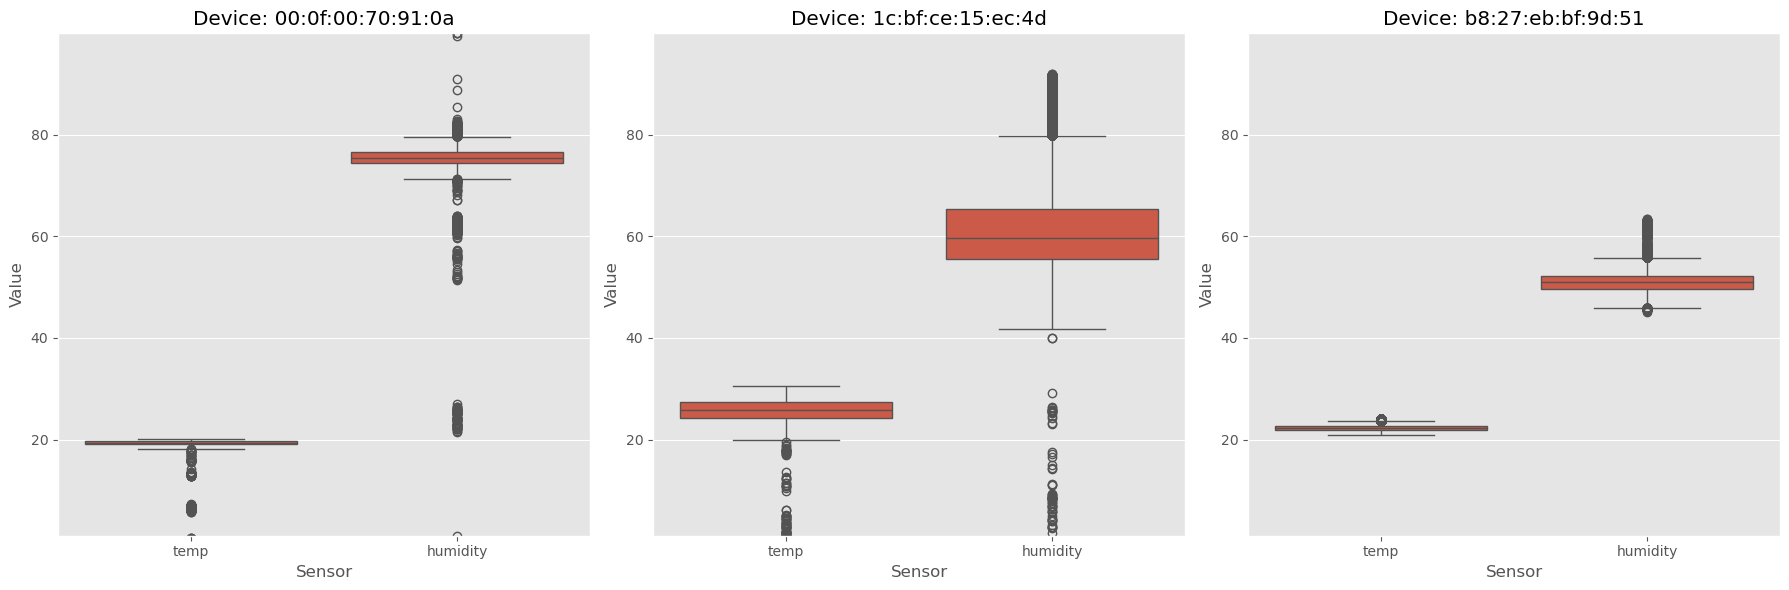

In [19]:
def plot_sensor_boxplots(device_df, sensors=['temp', 'humidity']):
    """
    Generate box plots for specified sensors from each device with same y-axis scale.

    Args:
    - device_df (dict): Dictionary with device IDs as keys and DataFrames as values.
    - sensors (list): List of sensors to plot.
    """

    num_devices = len(device_df)
    fig, axes = plt.subplots(nrows=1, ncols=num_devices, figsize=(num_devices * 6, 6))

    # Determine the global min and max values across all devices for each sensor
    global_min = {sensor: float('inf') for sensor in sensors}
    global_max = {sensor: float('-inf') for sensor in sensors}

    for df in device_df.values():
        for sensor in sensors:
            global_min[sensor] = min(global_min[sensor], df[sensor].min())
            global_max[sensor] = max(global_max[sensor], df[sensor].max())

    # Plot the box plots
    for j, (device_id, df) in enumerate(device_df.items()):
        data_to_plot = df[sensors].melt(var_name='Sensor', value_name='Value')
        sns.boxplot(x='Sensor', y='Value', data=data_to_plot, ax=axes[j])
        axes[j].set_title(f'Device: {device_id}')

        # Set the same y-axis limits for each subplot
        for i, sensor in enumerate(sensors):
            axes[j].set_ylim([global_min[sensor], global_max[sensor]])

    plt.tight_layout()
    plt.show()

plot_sensor_boxplots(device_df)

It is clear that the three devices are placed in different environments, each with distinct temperature and humidity patterns. The first two digits of each device label are used for identification.

Device 00 is situated in a cool and humid setting, suggesting a well-regulated indoor environment with consistent climate control.

Device 1c experiences a warm and moderately humid environment with noticeable fluctuations. These variations indicate less stringent climate control, where temperature and humidity are influenced by natural changes or human presence.

Device b8 is found in a warm and dry setting, also appearing to be well-regulated. Its stable readings suggest an environment with controlled conditions, similar to Device 00, but with different temperature and humidity levels.

From these observations, a preliminary hypothesis emerges: all devices are likely positioned indoors due to their stable environmental data. However, Device 1c shows greater variability, implying it is in a space with frequent human activity. Additionally, constant lighting (as detected by the light sensor) supports this assumption. It is plausible that Device 1c is located in a workshop with continuous use, while Device 00 and Device b8 may be in storage areas with minimal activity and consistent environmental management. Further analysis, particularly a closer look at daily readouts, is needed to confirm this hypothesis.

### Binary Data Processing
As we proceed, our analysis will focus on the motion and light sensor readouts.

Since the data is binary and does not effectively represent the intensity of sensor activity, we will apply a rolling average. This method will smooth out fluctuations, converting the binary readings into a more continuous and meaningful representation of sensor activity frequency.

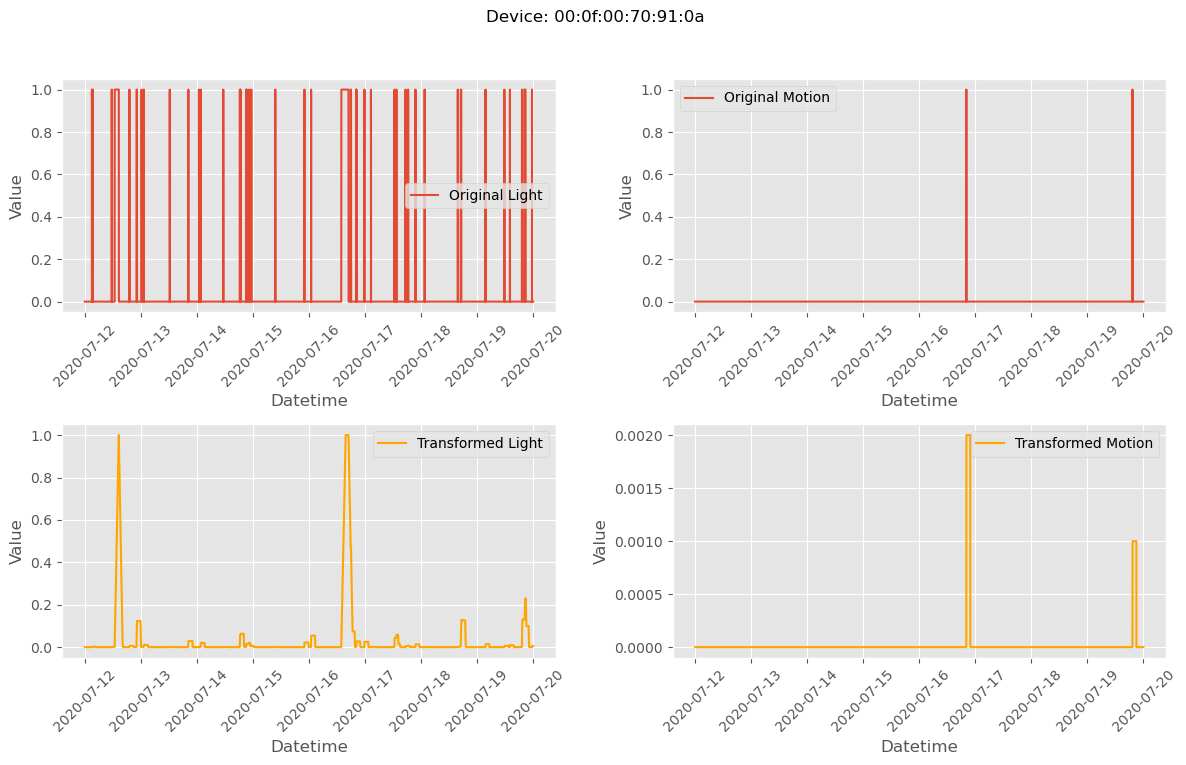

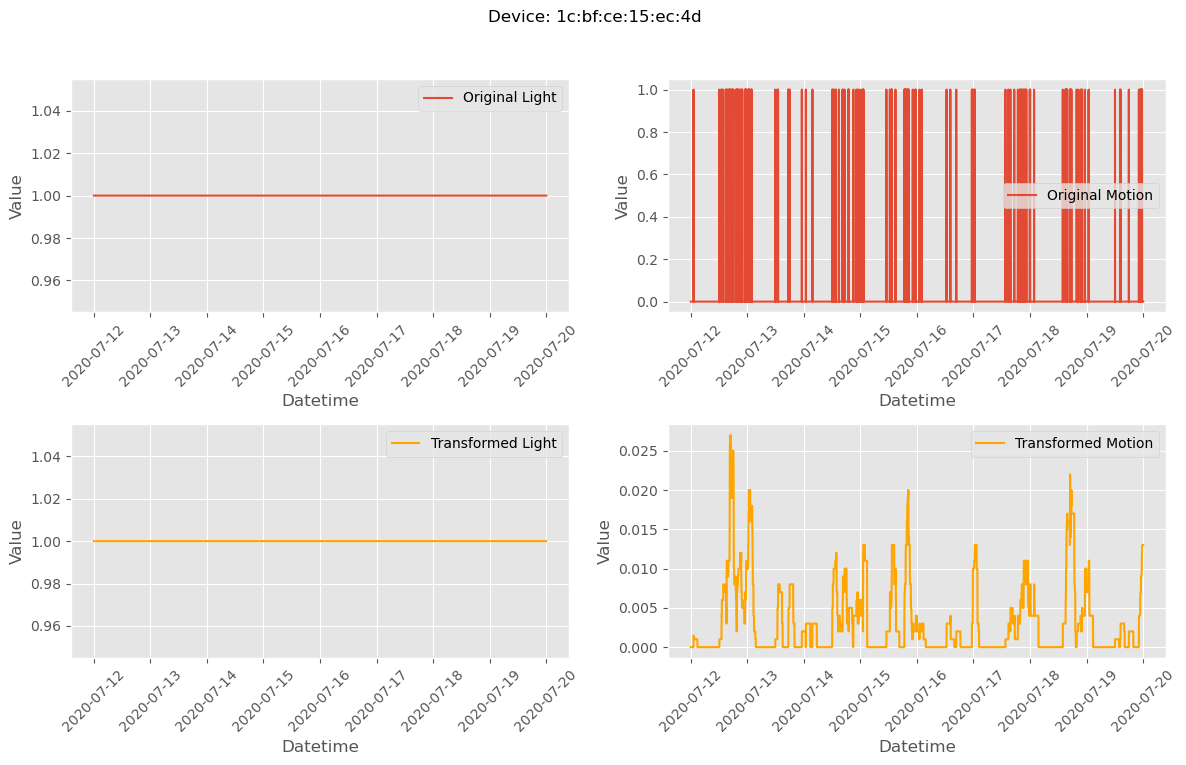

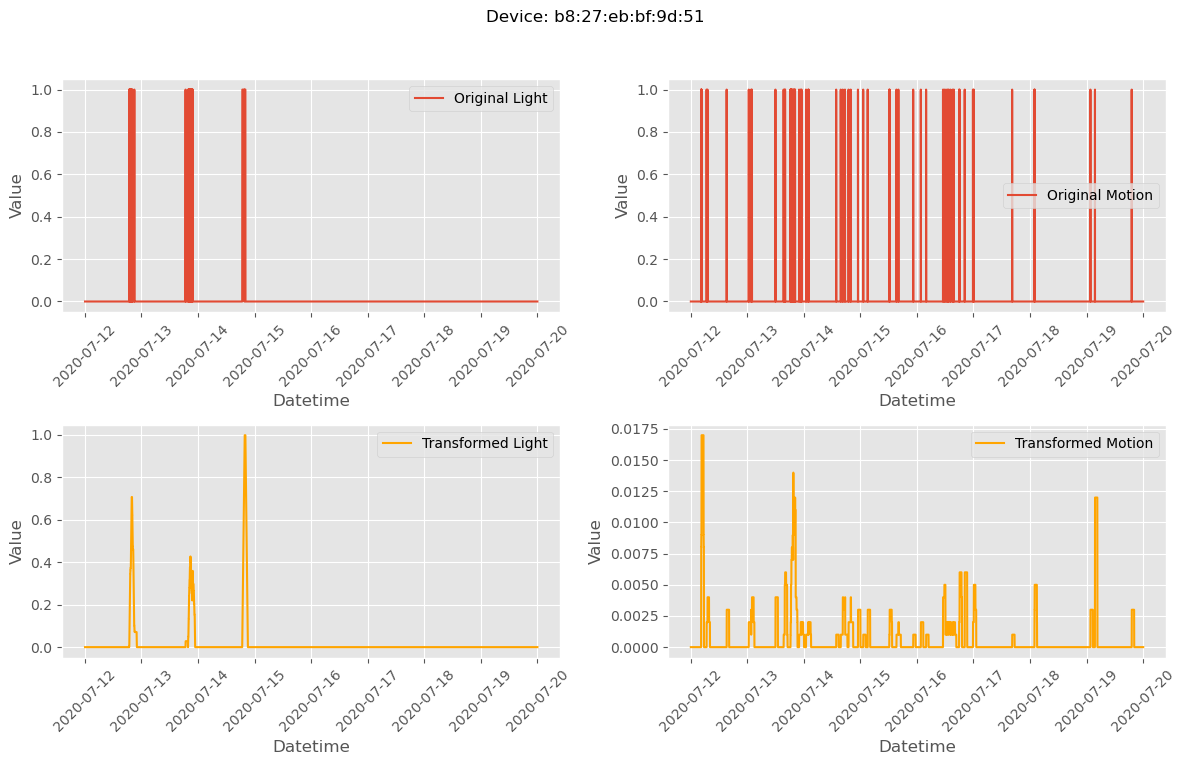

In [22]:
def transform_binary_to_frequency(df, window_size):
    """
    Transform binary signals to frequency rates using rolling window mean.

    Args:
    - df (DataFrame): DataFrame containing binary signals.
    - window_size (int): Size of the rolling window.

    Returns:
    - DataFrame: Transformed DataFrame.
    """
    df_transformed = df.rolling(window=window_size, min_periods=1).mean()
    return df_transformed

def plot_transformed_data(device_df, window_size):
    """
    Plot original and transformed binary signals.

    Args:
    - device_df (dict): Dictionary with device IDs as keys and DataFrames as values.
    - window_size (int): Size of the rolling window for transformation.
    """

    for device_id, df in device_df.items():
        # Transform binary signals
        df_transformed = transform_binary_to_frequency(df[['light', 'motion']], window_size)

        # Plotting
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
        fig.suptitle(f"Device: {device_id}")

        # Original Data
        axes[0, 0].plot(df.index, df['light'], label='Original Light')
        axes[0, 1].plot(df.index, df['motion'], label='Original Motion')

        # Transformed Data
        axes[1, 0].plot(df_transformed.index, df_transformed['light'], label='Transformed Light', color='orange')
        axes[1, 1].plot(df_transformed.index, df_transformed['motion'], label='Transformed Motion', color='orange')

        # Setting labels
        for i in range(2):
            for j in range(2):
                axes[i, j].set_xlabel('Datetime')
                axes[i, j].set_ylabel('Value')
                axes[i, j].legend()
                axes[i, j].tick_params(axis='x', rotation=45)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

window_size = 1000 # Adjustable until a sweet spot is found
plot_transformed_data(device_df, window_size)

### Autocorrelation - Detecting Seasonality
The graphs illustrate the light and motion sensor data both before and after applying a rolling average, converting the binary readings into a continuous format. The processed data is then merged back into the original grouped dataframe.

Subsequently, the precomputed sampling rates are used to generate autocorrelation plots, allowing us to identify seasonal patterns within the dataset.

C:\Users\HP\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\misc.py:457: RuntimeWarning: invalid value encountered in scalar divide
  return ((data[: n - h] - mean) * (data[h:] - mean)).sum() / n / c0


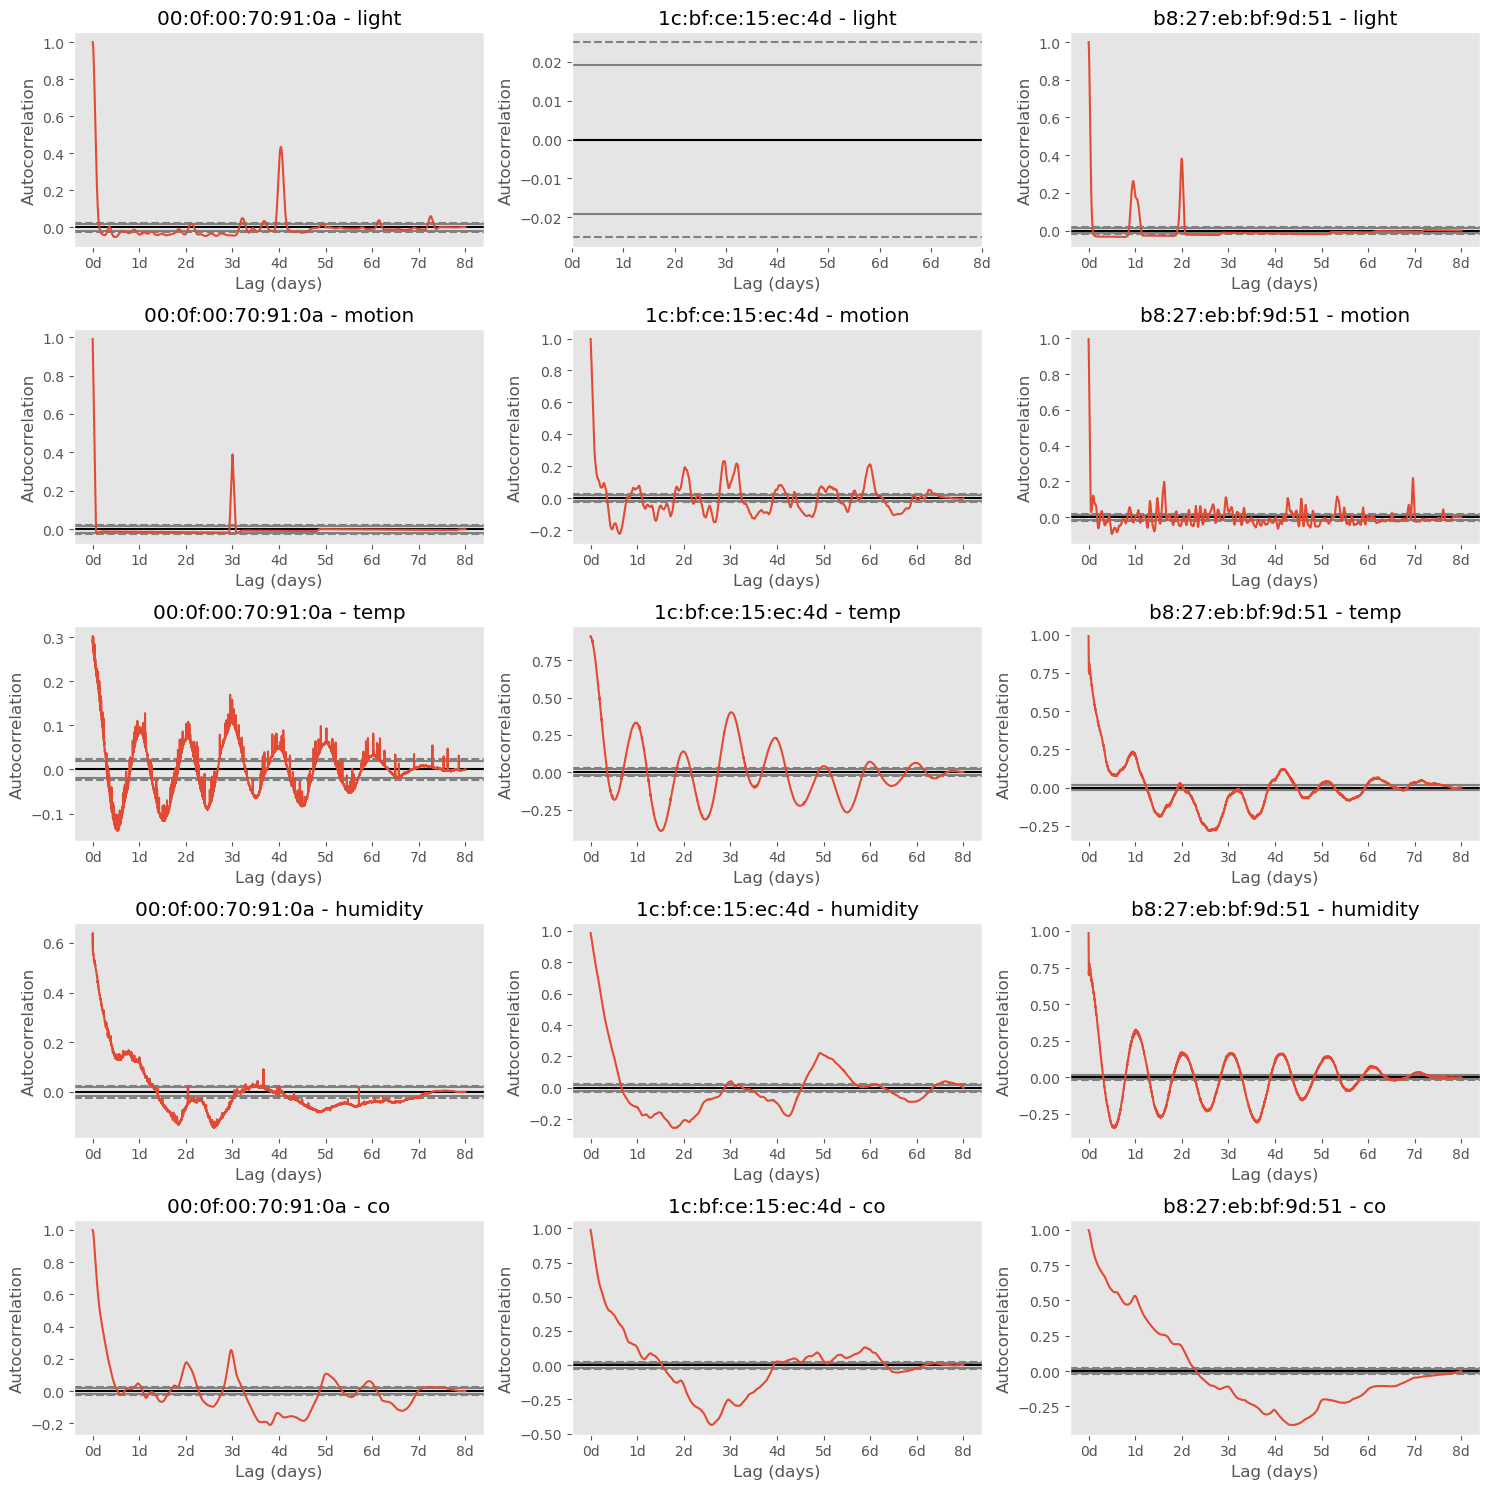

In [24]:
def plot_autocorrelation(device_df, undersample_rate=1, sampling_rates=None):
    """
    Generate autocorrelation plots for all sensors in all devices.

    Args:
    - device_df (dict): Dictionary with device IDs as keys and DataFrames as values.
    - undersample_rate (int): Rate at which to undersample the data for plotting efficiency.
    - sampling_rates (dict): Dictionary with device IDs as keys and average sampling rates as values.
    """

    # Sensors in the desired order
    sensors = ['light', 'motion', 'temp', 'humidity', 'co']

    # Number of devices and sensors
    num_devices = len(device_df)
    num_sensors = len(sensors)

    # Seconds in a day
    seconds_in_day = 24 * 60 * 60

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=num_sensors, ncols=num_devices, figsize=(num_devices * 5, num_sensors * 3))

    # Iterate through each device and sensor
    for j, (device_id, df) in enumerate(device_df.items()):
        # Calculate number of samples in a day
        samples_per_day = seconds_in_day / (sampling_rates[device_id] * undersample_rate)
        
        # Undersample the data
        df_undersampled = df.iloc[::undersample_rate, :]

        for i, sensor in enumerate(sensors):
            # Create autocorrelation plot for each sensor
            autocorrelation_plot(df_undersampled[sensor], ax=axes[i][j])
            axes[i][j].set_title(f'{device_id} - {sensor}')
            axes[i][j].set_xlabel('Lag (days)')
            axes[i][j].set_ylabel('Autocorrelation')

            # Adjust x-axis to represent days
            max_lag = df_undersampled[sensor].shape[0]
            xticks = np.arange(0, max_lag, samples_per_day)
            xticklabels = [f"{int(lag/samples_per_day)}d" for lag in xticks]
            axes[i][j].set_xticks(xticks)
            axes[i][j].set_xticklabels(xticklabels)

    plt.tight_layout()
    plt.show()

# Apply the transformation to binary data
window_size = 1000
for device_id in device_df:
    device_df[device_id][['light', 'motion']] = transform_binary_to_frequency(device_df[device_id][['light', 'motion']], window_size)

# Sampling rates for each device
sampling_rates = {
    '00:0f:00:70:91:0a': 6.182787879460532,
    '1c:bf:ce:15:ec:4d': 6.526965254047981,
    'b8:27:eb:bf:9d:51': 3.6880388281568415
}

plot_autocorrelation(device_df, undersample_rate=10, sampling_rates=sampling_rates)

**Device: 00:0f:00:70:91:0a**

This device exhibits strong seasonality, with clear periodic trends in temperature, humidity, and motion. The temperature and humidity show cyclical variations, likely reflecting daily or multi-day environmental changes. Motion and light data display distinct spikes, indicating recurring activity patterns, possibly due to human presence or scheduled lighting changes. CO levels have weaker but still structured periodicity, suggesting slow-varying environmental effects. Overall, this is the most seasonal device with well-defined cycles.

**Device: 1c:bf:ce:15:ec:4d**

This device shows minimal seasonality, with light data remaining completely constant, suggesting either an always-on or permanently dark environment. Motion data shows weak periodicity, indicating occasional activity but not strong recurring patterns. Temperature, humidity, and CO levels display low autocorrelation, meaning they change more randomly rather than following clear cycles. Given the lack of strong periodic trends, this is the least seasonal device.

**Device: b8:27:eb:bf:9d:51**

This device demonstrates moderate seasonality, with temperature and humidity following periodic trends, though weaker than those seen in 00:0f:00:70:91:0a. Light and motion data indicate sporadic activity rather than consistent daily patterns. CO levels show a gradual decay in autocorrelation, suggesting slow-changing environmental effects rather than a strong periodic cycle. While some seasonal elements exist, they are not as pronounced, making this device moderately seasonal.

### Daily trends
We analyze and compare the daily variations across all devices.

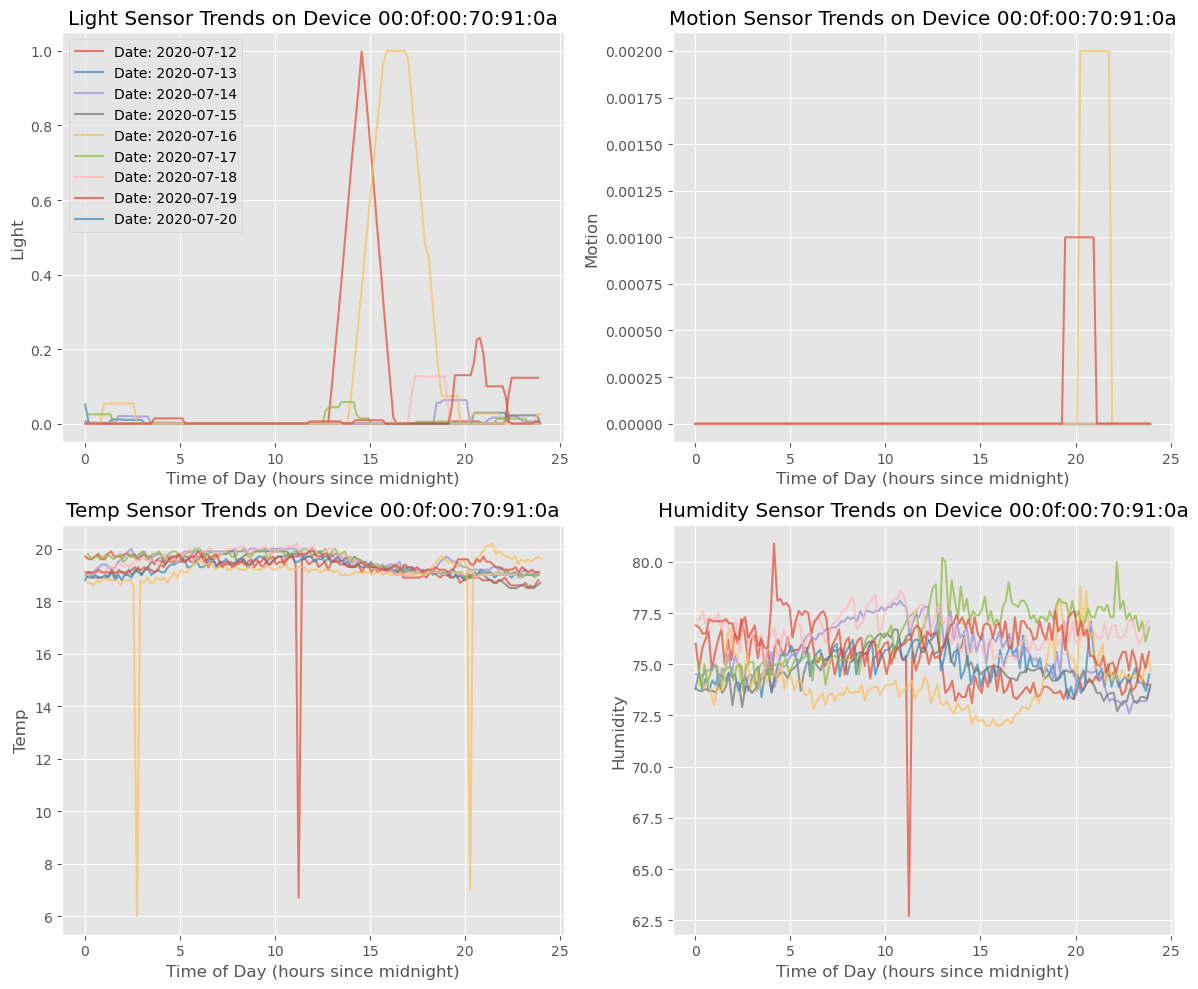

In [27]:
def convert_time_to_hours(time_obj):
    """
    Convert a time object to hours since midnight.

    Args:
    - time_obj (datetime.time): Time object to convert.

    Returns:
    - float: Number of hours since midnight.
    """
    return time_obj.hour + time_obj.minute / 60 + time_obj.second / 3600

def plot_daily_trends_for_sensors(device_df, device_id, sensors, undersample_rate=100, window_size=1):
    """
    Plot daily trends of multiple sensors from a device in a 2x2 matrix with legends indicating dates.

    Args:
    - device_df (dict): Dictionary with device IDs as keys and DataFrames as values.
    - device_id (str): The ID of the device to plot.
    - sensors (list): List of sensors to plot.
    - undersample_rate (int): Rate at which to undersample the data.
    - window_size (int): Window size for moving average.
    """
    df = device_df[device_id]

    # Create a 2x2 subplot grid
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for i, sensor in enumerate(sensors):
        # Undersample and apply moving average
        df_resampled = df.iloc[::undersample_rate, :]
        df_smoothed = df_resampled[sensor].rolling(window=window_size, min_periods=1).mean()

        # Group by date and plot each day's data
        for date, group in df_smoothed.groupby(df_smoothed.index.date):
            # Convert index time to hours
            hours_since_midnight = [convert_time_to_hours(t) for t in group.index.time]
            axes[i].plot(hours_since_midnight, group, alpha=0.7, label=f'Date: {date}')

        axes[i].set_title(f'{sensor.capitalize()} Sensor Trends on Device {device_id}')
        axes[i].set_xlabel('Time of Day (hours since midnight)')
        axes[i].set_ylabel(f'{sensor.capitalize()}')
        if i == 0:
            axes[i].legend()

    # Adjust layout and show plot
    fig.tight_layout()
    plt.show()

sensors = ['light', 'motion', 'temp', 'humidity']
plot_daily_trends_for_sensors(device_df, '00:0f:00:70:91:0a', sensors)

### Device 00:0f:00:70:91:0a

Device 00:0f:00:70:91:0a  exhibits clear daily trends in its environmental and motion sensors. The light sensor data shows sharp peaks around the afternoon to evening hours, suggesting structured lighting activity, possibly due to human intervention. The motion sensor trends align with the light sensor, showing brief but distinct spikes, implying periodic but infrequent movement in the environment. Temperature readings remain relatively stable throughout the day but show occasional sharp drops, which may indicate sensor anomalies or brief environmental fluctuations and mostly remain within 18 degrees to 20 degrees. Humidity is on the higher side (between around 75% to 88%) and its levels display some variations. However, it maintains a consistent pattern, with occasional dips possibly linked to temperature fluctuations. These trends reinforce the strong seasonality observed in this device’s autocorrelation analysis, confirming structured and periodic environmental changes. Based on the observed trends, device 00:0f:00:70:91:0a is likely situated in an environment with structured human activity and controlled lighting conditions. 

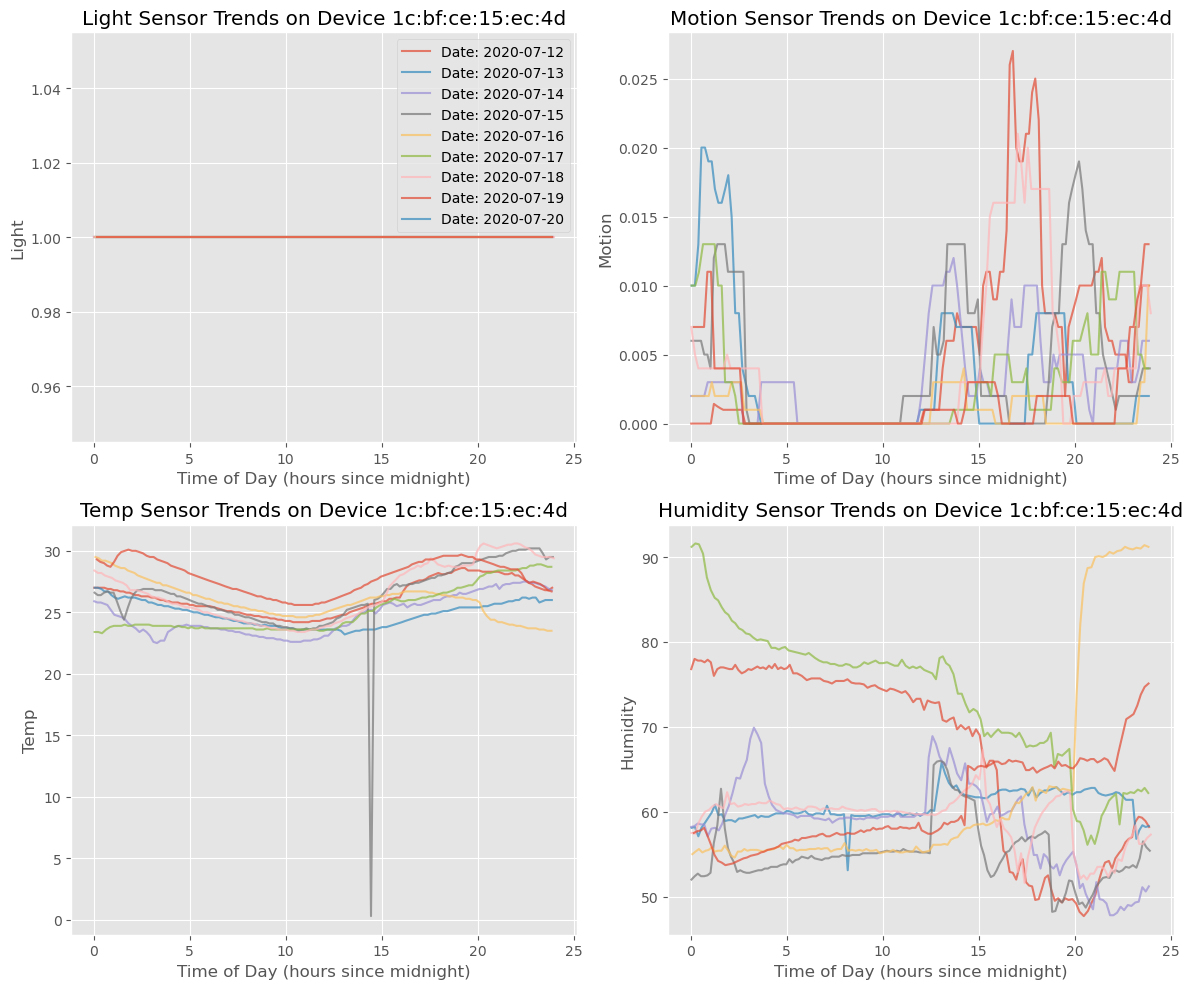

In [29]:
plot_daily_trends_for_sensors(device_df, '1c:bf:ce:15:ec:4d', sensors)

### Device 1c

Device 1c:bf:ce:15:ec:4d exhibits distinct sensor behaviors across different parameters, indicating a dynamic or irregular environment. The light sensor remains completely static at a constant value of 1.00, suggesting either continuous exposure to artificial lighting, a malfunction, or placement in an area with unchanging brightness, such as a storage room or an outdoor location under a permanent light source. The motion sensor readings show intermittent spikes throughout the day, particularly peaking around 15-20 hours, indicating occasional activity without a clear daily cycle, which could be characteristic of an infrequently accessed space like a warehouse, a parking garage, or a conference room with sporadic human presence. The temperature sensor demonstrates a weak diurnal trend with a range between 24 degrees and 30 degrees Celsius. Temperatures dip in the early hours and rise later but lack sharp periodicity, possibly reflecting an environment with controlled but inconsistent heating/cooling, such as a greenhouse, an industrial facility, or a semi-outdoor setting. The presence of occasional extreme anomalies, like sudden temperature drops, may suggest exposure to external weather conditions or air conditioning bursts. The humidity sensor shows erratic fluctuations, with some days experiencing sharp declines while others display steady variations, which could indicate an environment with fluctuating ventilation, such as a basement, a laboratory with humidity control systems, or an open-air workspace exposed to varying weather conditions. These patterns suggest that device 1c is likely in a non-residential, semi-controlled, or industrial-like setting with unpredictable environmental changes rather than a stable indoor home or office.


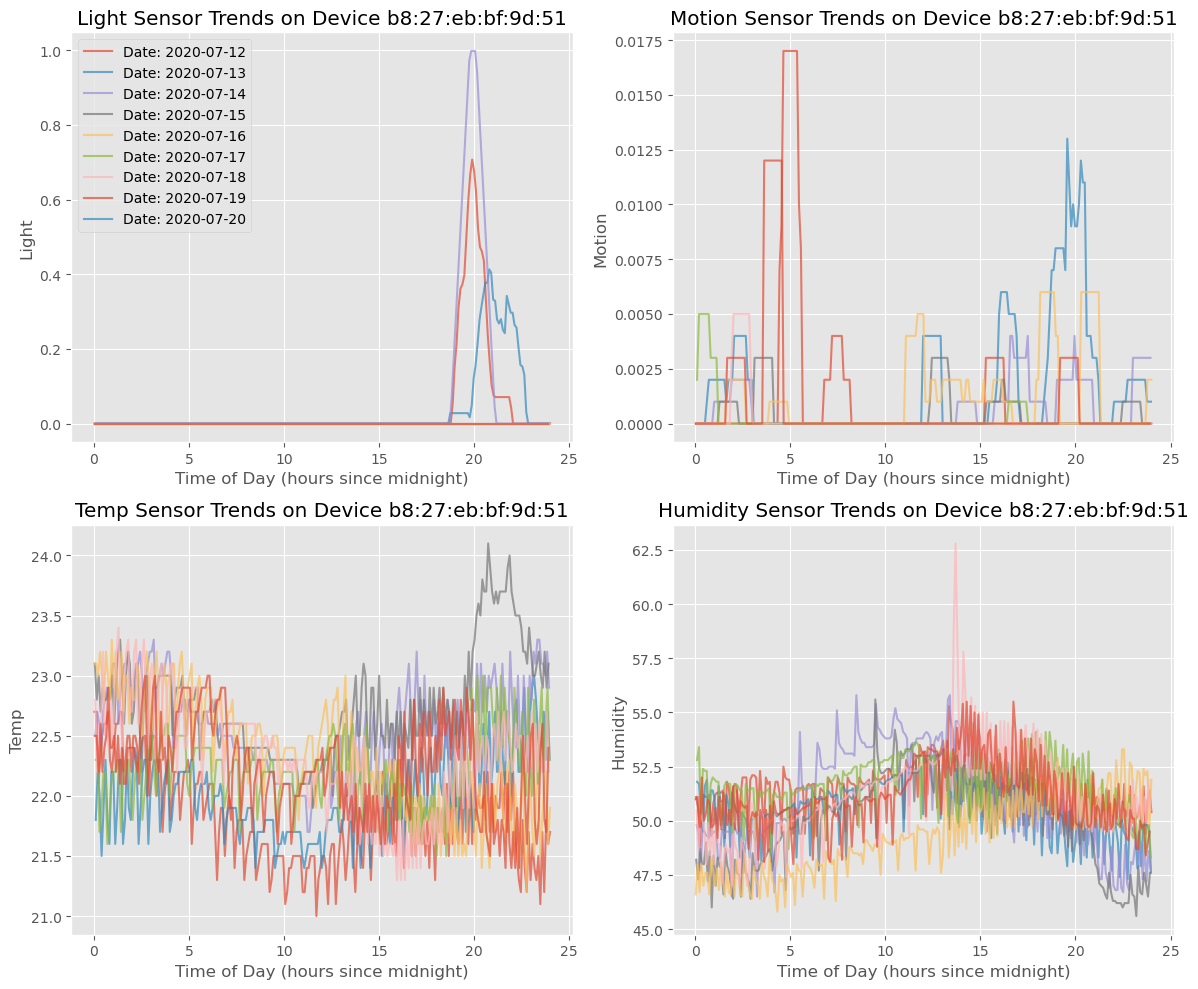

In [31]:
plot_daily_trends_for_sensors(device_df, 'b8:27:eb:bf:9d:51', sensors)

### Device b8

Device b8:27:eb:bf:9d:51 shows structured environmental trends, with sharp evening light peaks indicating artificial lighting use and sporadic motion spikes suggesting periodic activity. Temperature remains stable between 21°C and 24°C, while humidity trends gradually rise from 45% to 62%, likely influenced by ventilation or human presence. These patterns suggest the device is in a controlled environment such as an office, warehouse, home, server room, or library, where lighting, movement, and climate are regulated based on routine activities.

### Final Insights

Device 00:0f:00:70:91:0a appears to be in an active indoor setting with structured lighting changes and periodic human movement, possibly an office or a lab with scheduled activity. Device 1c:bf:ce:15:ec:4d is situated in a high-traffic area with constant lighting and fluctuating environmental factors, suggesting locations like a workshop, warehouse, or industrial facility. Device b8:27:eb:bf:9d:51 is in a stable and controlled environment with minimal activity, likely a storage room or a data center. All three devices are indoors, but their differing environmental trends highlight distinct use cases: structured human activity (Device 00), unpredictable but frequent movement (Device 1c), and a well-regulated, low-traffic space (Device b8). Next we'll be focusing on predictive analytics

## Predictive Analytics

Our goal now is to build a Machine Learning model to predict the conditions of the immediate surroundings. But, to do that we will first require a dependent variable which is not apparent in the dataset. However, we can infer a dependent variable from the insights as obtained from the previous visualizations.

1. Device 00:0f:00:70:91:0a is associated with stable conditions, cooler temperatures and higher humidity.
2. Device 1c:bf:ce:15:ec:4d is associated with highly variable temperature and humidity.
3. Lastly, device b8:27:eb:bf:9d:51 is associated with stable conditions, warmer termperature and dryer surroundings.

Hence, we can create a dependent variable that maps the following characteristics to these devices. Lastly, we remove the column containing the device identifier, as not removing it would lead to inflated metrics.

In [3]:
device_df = pd.read_csv(r"C:\Users\HP\Desktop\iot_telemetry_data.csv", engine='python')

device_df['target'] = device_df['device'].map({"00:0f:00:70:91:0a":"0","1c:bf:ce:15:ec:4d":"1", "b8:27:eb:bf:9d:51":"2"})
dataEnc = device_df.copy().drop(['ts'],axis = 1).drop( ['device'],axis = 1) 
dataEnc

,co,humidity,light,lpg,motion,smoke,temp,target
0,0.004956,51.000000,False,0.007651,False,0.020411,22.700000,2
1,0.002840,76.000000,False,0.005114,False,0.013275,19.700001,0
2,0.004976,50.900000,False,0.007673,False,0.020475,22.600000,2
3,0.004403,76.800003,True,0.007023,False,0.018628,27.000000,1
4,0.004967,50.900000,False,0.007664,False,0.020448,22.600000,2
...,...,...,...,...,...,...,...,...
405179,0.003745,75.300003,False,0.006247,False,0.016437,19.200001,0
405180,0.005882,48.500000,False,0.008660,False,0.023301,22.200000,2
405181,0.004540,75.699997,True,0.007181,False,0.019076,26.600000,1
405182,0.003745,75.300003,False,0.006247,False,0.016437,19.200001,0


Here, Label 0 = stable conditions, cooler temperatures and higher humidity.

Label 1 = highly variable temperature and humidity.

and Lastly, Label 2 = stable conditions, warmer termperature and dryer surroundings.

We proceed by removing 'lpg' and 'smoke' features as they are highly correlated with 'co' feature.

In [4]:
dataEnc['light'] = dataEnc['light'].map({False:0, True:1})
dataEnc['motion'] = dataEnc['motion'].map({False:0, True:1})
dataEnc = dataEnc.drop(['lpg'], axis = 1).drop(['smoke'], axis = 1)

In [5]:
y = dataEnc['target']
X = dataEnc.drop(['target'], axis = 1)

In [6]:
# train test validation split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=0)
x_Train, x_Val, y_Train, y_Val = train_test_split(x_train, y_train,test_size=0.2, random_state=0 )
#

### Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  confusion_matrix , accuracy_score, f1_score
lr_model = LogisticRegression()
lr_model.fit(x_Train, y_Train)
predResult = lr_model.predict(x_Val)
acc = accuracy_score(y_Val, predResult)
confMat = confusion_matrix(y_Val, predResult)
f1 = f1_score(y_Val, predResult, average = 'weighted')
print(confMat)
print(f"accuracy: {acc*100}%")
print(f"f1: {f1*100}%")

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[17903     9     7]
 [   17 16731    10]
 [   25   348 29780]]
accuracy: 99.35832176461514%
f1: 99.35945560297125%


### Decision Tree Model

In [15]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
dt_model.fit(x_Train, y_Train)
predResult =dt_model.predict(x_Val)
acc = accuracy_score(y_Val, predResult)
confMat = confusion_matrix(y_Val, predResult)
f1 = f1_score(y_Val, predResult, average = 'weighted')
print(confMat)
print(f"accuracy: {acc*100}%")
print(f"f1: {f1*100}%")

[[17919     0     0]
 [    0 16757     1]
 [    0     0 30153]]
accuracy: 99.99845750424187%
f1: 99.99845749401854%


All models exhibit good performance.

### Explainable AI with SHAP

In [31]:
import shap
x_test_np = np.array(x_test)
explainer = shap.Explainer(dt_model, x_test_np)
shap_values = explainer(x_test_np)


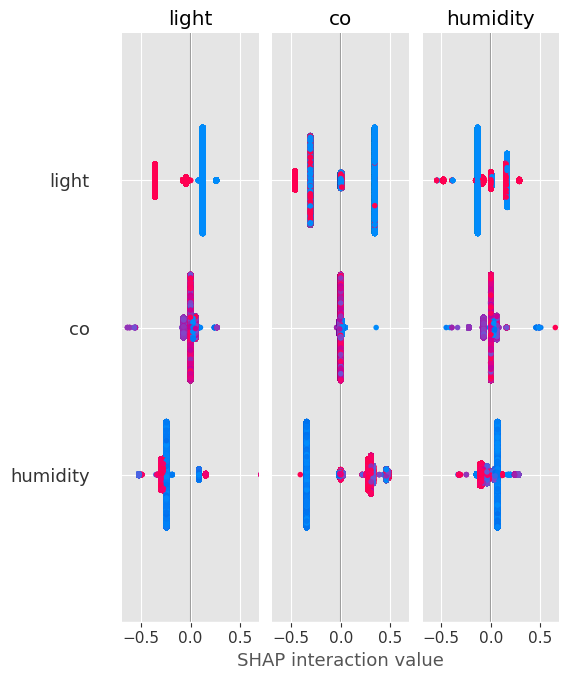

In [32]:
shap.summary_plot(shap_values, x_test)

This SHAP interaction plot illustrates how the features light, CO, and humidity interact within the machine learning model, influencing its predictions. 

The x-axis represents SHAP interaction values, indicating the degree to which feature interactions contribute to model outputs, while the y-axis lists the interacting features.

The color gradient, where red represents lower values and blue represents higher values, provides additional insight into how different feature values impact these interactions. 

### To conclude:

1. The plot suggests that the feature **light** has a strong interaction with itself and moderate interactions with **CO** and **humidity**, implying that variations in **light** significantly influence the model's predictions.
2. Similarly, **CO** demonstrates noticeable but more centralized interactions with both **light** and **humidity**, indicating that it plays a moderate but consistent role in shaping the predictions.
3. Meanwhile, **humidity** exhibits strong interactions with both **light** and **CO**, suggesting a non-linear dependency where changes in humidity significantly modify the model’s response based on other features. The varying SHAP values indicate that the model leverages feature dependencies rather than treating them independently, emphasizing complex relationships. These insights imply that the model accounts for non-linear interactions and potential collinearity among the variables, which could either improve prediction accuracy or introduce redundancy. 